In [39]:
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
import zarr as zr
import django
from dask.distributed import Client, progress

django.setup()
from bioconverter import models
from dask.distributed import Client, progress
c = Client()
import xarray as xr

In [40]:
reps = models.Representation.objects.all()

In [41]:
reps.zarr.id

AttributeError: 'RepresentationQuerySet' object has no attribute 'zarr'

In [42]:
maxisp = reps.filter(name__startswith="Max ISP").last()

In [43]:
maxisp.zarr.id

85

In [44]:
import dask_image.ndfilters

<xarray.DataArray 'data' (x: 1024, y: 1024, channel: 3, time: 1)>
dask.array<zarr, shape=(1024, 1024, 3, 1), dtype=float64, chunksize=(128, 256, 1, 1)>
Coordinates:
  * channel  (channel) <U18 'Alexa 488 antibody' 'Alx568' 'Alx647'
    physx    (x) float64 dask.array<chunksize=(1024,), meta=np.ndarray>
    physy    (y) float64 dask.array<chunksize=(1024,), meta=np.ndarray>
  * time     (time) int64 0
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1017 1018 1019 1020 1021 1022 1023
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1017 1018 1019 1020 1021 1022 1023
Attributes:
    channels:  [{'AcquisitionMode': None, 'Color': '16711935', 'EmissionWavel...
    planes:    [{'DeltaT': '1.2962702235234902', 'PositionX': None, 'Position...
    scan:      [{'PhysicalSizeX': '0.2071601898007465', 'PhysicalSizeXUnit': ...

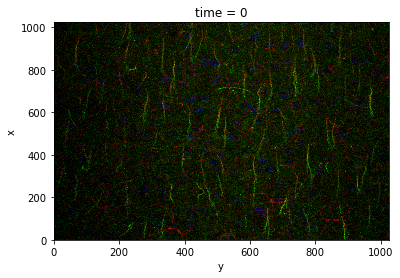

In [10]:
maxisp.array.sel(time=0).plot.imshow()

In [35]:
@xr.register_dataarray_accessor("helpers")
class HelperAccesor:
    def __init__(self, xarray_obj):
        self._obj = xarray_obj
        self._channelvalue = None
        self._channeldict = None
        self._planesdict = None
        self._planes = None

    def appendChannel(self, size=1, name=None, dim="channel", constructor=da.zeros, tosize=None):
        """Return the geographic center point of this dataset."""
        if name is None:
            name = f'empty-{dim}'
        newshape = list(self._obj.shape)
        oldsize = newshape[self._obj.dims.index(dim)]
        if (oldsize >= tosize): return self._obj
        if tosize is not None: size = tosize - oldsize
        if tosize is not None:
            newshape[self._obj.dims.index(dim)] = size
        else:   
            newshape[self._obj.dims.index(dim)] = size
        for i in range(size): 
            self._obj.attrs["channels"].append({"Type": "Fake Zeros", "Name": f"{name}-{i}"})
        # we can use a cache on our accessor objects, because accessors
        # themselves are cached on instances that access them.
        zeros = xr.DataArray(constructor(newshape), dims=["x","y","channel","time"], coords={**self._obj.coords, dim:[f"{name}-{x}" for x in range(size)]}, name=self._obj.name, attrs=self._obj.attrs)
        return xr.concat([self._obj,zeros],dim=dim)
    
    @property
    def scan(self):
        """Return the geographic center point of this dataset."""
        return pd.DataFrame(self._obj.attrs["scan"])

    @property
    def planes(self):
        """Return the planes of this Xarray."""
        # we can use a cache on our accessor objects, because accessors
        # themselves are cached on instances that access them.

        if self._planesdict is None:
            self._planesdict = {}
            try:
                for item in self._obj.attrs["planes"]:
                    self._planesdict[item["TheZ"]] = item
            except KeyError:
                raise NotImplementedError("The Array you are interfacing with is not an Arnheim array with the required Biometa Attributes")
        try:
            values = [self._planesdict[str(value)] for value in self._obj.z.values]
        except TypeError as e:
            values = [self._planesdict[str(self._obj.z.values)]]
        except KeyError as e:
            raise NotImplementedError("This X-Array does not containt a Z-Axis")

        self._planevalues = values
        return pd.DataFrame(self._planevalues)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: AccessorRegistrationWarning: registration of accessor <class '__main__.HelperAccesor'> under name 'helpers' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  """Entry point for launching an IPython kernel.


In [36]:
newchannel = maxisp.array.helpers.appendChannel(tosize=10)

In [37]:
newchannel.biometa.channels

,AcquisitionMode,Color,EmissionWavelength,ExcitationWavelength,IlluminationType,Name,SamplesPerPixel,Type
0,NaN,16711935,535.0,NaN,NaN,Alexa 488 antibody,1,NaN
1,NaN,-16776961,590.0,NaN,NaN,Alx568,1,NaN
2,NaN,65535,825.0,NaN,NaN,Alx647,1,NaN
3,NaN,NaN,NaN,NaN,NaN,empty-channel-0,NaN,Fake Zeros
4,NaN,NaN,NaN,NaN,NaN,empty-channel-1,NaN,Fake Zeros
5,NaN,NaN,NaN,NaN,NaN,empty-channel-2,NaN,Fake Zeros
6,NaN,NaN,NaN,NaN,NaN,empty-channel-3,NaN,Fake Zeros
7,NaN,NaN,NaN,NaN,NaN,empty-channel-4,NaN,Fake Zeros
8,NaN,NaN,NaN,NaN,NaN,empty-channel-5,NaN,Fake Zeros
9,NaN,NaN,NaN,NaN,NaN,empty-channel-6,NaN,Fake Zeros


In [34]:
volume2 = xarray.concat([zeros,maxisp.array],dim="channel").max(dim="time").sel(channel="Ch1-T1")

ValueError: arguments without labels along dimension 'x' cannot be aligned because they have different dimension size(s) {1256} than the size of the aligned dimension labels: 1024

In [30]:
volume2.dtype

dtype('float64')

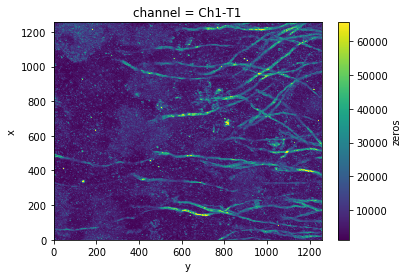

In [31]:
volume2.plot.imshow()



In [53]:
it = maxisp.array.sel(time=0).sel(channel=maxisp.array.channel[0])

In [57]:
import dask_image.ndfilters
lalafarbe = dask_image.ndfilters.prewitt(it.data)

In [58]:
lala = xr.DataArray(lalafarbe, coords=it.coords, name="data", attrs=it.attrs)

In [60]:
lala.biometa.channels

,AcquisitionMode,Color,EmissionWavelength,ExcitationWavelength,IlluminationType,Name,SamplesPerPixel
0,None,16711935,535.0,None,None,Alexa 488 antibody,1


In [65]:
import matplotlib.pyplot as plt

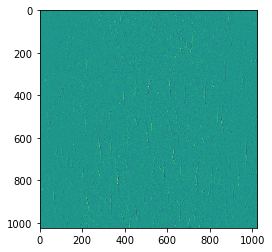

In [67]:
plt.imshow(lala.data)